In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [330]:
data = pd.read_csv("data/0mA(29s)~30mA(1s)_(DODI_C).csv") #통합 데이터
data.describe()

,Voltage(V),Current(A),Resistance(Ohm),Power(W)
count,4.988486e+06,4.988486e+06,4.988486e+06,4.988486e+06
mean,3.889299e+00,9.340380e-04,1.300571e+04,3.475257e-03
std,3.141821e-02,5.146647e-03,5.870463e+04,1.871865e-02
min,1.680000e-02,-1.500000e-03,0.000000e+00,0.000000e+00
25%,3.888700e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.894900e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.899500e+00,0.000000e+00,1.219480e+02,0.000000e+00
max,3.907000e+00,1.399000e+00,6.489843e+05,1.340000e-01


### 데이터 자르기 (time, volt, current)

In [331]:
data = data.iloc[:, :3] #.values

### 시간을 timedelt로 변경하기 위함

In [332]:
date_=[] #replace korean to english

for i in data['Time'].values:
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)

In [333]:
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))

In [334]:
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)

In [335]:
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)

100%|█████████████████████████████████████████████████████████████████████| 4988486/4988486 [07:32<00:00, 11031.92it/s]


### 기준 전압 인덱스 구하기

#### 통신 전류가 시작하는 곳의 직전 인덱스를 기준 전압으로 하였으나 기준이 애매하여 기준을 변경

#### 전압이 낮아지는 곳이 통신이 시작하는 부분

#### 통신 전류가 시작하는 곳의 전압값과 이전 인덱스의 전압값을 비교하여 이전 인덱스의 전압값이 더 크다면 기준 전압으로 하고 그렇지 않다면 기준 전압으로 하지 않는다
1. $> 0.020$ 을 통신 전류로 하여 임시 기준 전압 인덱스를 찾는다
2. 임시 기준 전압값(t)과 그 이전 전압값(t-1)을 비교한다.
3. 이전 전압값(t-1)이 임시 기준 전압값(t)보다 크다면 그 값이 기준 전압값!
4. 같다면 임시 기준 전압값(t)과 전전 전압값(t-2)를 비교
5. 반복


In [336]:
comm_A = np.where(data['Current(A)'] > 0.020) #통신 전류

In [337]:
comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스

In [338]:
comm_V = np.array(comm_V_).reshape(len(comm_V_[0]))

#### 전압이 2v이상인 통신 전류 데이터 인덱스

In [339]:
comm_ = comm_A

for i in comm_V:
    comm_ = np.delete(comm_, np.where(comm_ == i))

#### 전압이 2v이하이면서 통신 전류가 흐르는 데이터가 없는 경우

In [69]:
comm_ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에

In [70]:
comm_

array([      3,       4,       5, ..., 4988382, 4988383, 4988384],
      dtype=int64)

#### 통신 전류 시작 인덱스 하나만

In [340]:
comm = np.array([comm_[0]])

for idx in range(int(len(comm_)-1)):
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, np.array(comm_[idx+1]))

In [341]:
comm

array([    132,     268,     401, ..., 4988164, 4988274, 4988381],
      dtype=int64)

#### 임시 기준 전압(t)은 통신 시작 전류 인덱스 바로 전

In [418]:
t_crit = comm - 1

In [419]:
t_crit.shape

(59559,)

#### 전압이 떨어지기 전의 전압값의 인덱스를 찾아야 함
    - 여기서 인덱스를 잘 골라내야 함!!
    - 전압이 감소하면서 전류가 증가하는 부분이 통신 구간의 시작이다
    - 기존  > 0.020으로 한 경우에는 한 번의 통신에 인덱스가 더 추가된 부분이 있을 수 있음
        - 한 번 더 처리를 한 후에 같은 값(인덱스)가 있으면 제거 (중복 제거)
$ \therefore\; > 0.020 $ 인 부분이면서 전압이 (-), 전류가 (+)인 부분이 최종 통신 시작 인덱스!!

In [895]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t #tmp는 >0.020 이전의 전압 인덱스
#     cnt = 0
#     loop = 0
#     print('tmp', tmp, "t", t)
    for i in range(1, 5):
#         loop = i
#         print('i', i, 'tmp', tmp, "t", t)
        #전압 (+), 전류 (-) => 이전 인덱스
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]): # and ((data['Current(A)'][t-i] != 0.0000) or (data['Current(A)'][tmp] != 0.0000)): # and (data['Current(A)'][tmp] > data['Current(A)'][t-i])
            tmp = t-i
        #전압 (-), 전류 (+) => 이전 인덱스
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압 (+), 전류 그대로 => 이전 인덱스
#         elif (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] == data['Current(A)'][t-i]): # and (data['Current(A)'][tmp] != 0.0000):
#             tmp = t-i
#         #전압, 전류 그대로 or 전압 (-), 전류 그대로 => 인덱스 유지
#         elif not(data['Voltage(V)'][tmp] < data['Voltage(V)'][tmp-i]) and not(data['Current(A)'][tmp] < data['Current(A)'][tmp-i]):
#             cnt += 1
        else: #인덱스를 유지해야 하는 경우를 세기
            continue
#             cnt = cnt + 1   
    #tmp - 반복 횟수 + 바뀌지 않은 인덱스
    ref = np.append(ref, tmp)
#     print('tmp', tmp, 't', t, 'cnt', cnt, 'ref', ref)
            
ref = np.unique(ref) #중복 값 제거



#         if data['Voltage(V)'][tmp] == data['Voltage(V)'][tmp-i]: #같으면 t가 그대로
#             tmp = t
#         if (data['Voltage(V)'][tmp] < data['Voltage(V)'][tmp-i]) and (0.000 < data['Current(A)'][tmp-i] < 0.010): #작으면 tmp = t-1
#             tmp = t-i
#         if data['Current(A)'][tmp] > 0.020:
#             tmp = t-i
#         if data['Voltage(V)'][tmp] > data['Voltage(V)'][tmp-i]: #크면 그 값이 기준 전압값의 인덱스
#             t_crit = np.append(t_crit, tmp)
#             break

100%|██████████████████████████████████████████████████████████████████████████| 59559/59559 [00:10<00:00, 5752.78it/s]


In [881]:
ref.shape

(59557,)

In [882]:
data['Voltage(V)'][1931]

3.8957

### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [ ]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
# index = np.zeros((1,3), dtype=int)

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    for j in range(1, int(len(data['Voltage(V)']))):
#         print("crit", i, "current", i+j+1)
#         print("crit", data['Voltage(V)'][i], "current", data['Voltage(V)'][j+i+2])
        if (recovery_volt.shape[0] == 29123):
                print("r", r, "v", v, "i", data['Voltage(V)'][i], "i+j", data['Voltage(V)'][i+j])    
        
            
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j]) * 100 #(기준전압 - 현재전압)*100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가
        
#         print("rate", rate)
#         print("recovery_rate", recovery_rate)

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([parsing_date[i], parsing_date[i+j]]).reshape(1,2), axis=0)
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)
            
#             index = np.append(index, np.array([]))
            if (recovery_volt.shape[0] == 29123):
                print("r", r, "v", v, "i", i, "i+j", i+j)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

 49%|████████████████████████████████████▊                                      | 29200/59557 [00:29<00:57, 531.64it/s]

r [0.02] v [3.8951] i 2682946 i+j 2682947
r [] v [] i 3.8952 i+j 3.7109
r [18.43] v [3.7109] i 3.8952 i+j 3.7068
r [18.43 18.84] v [3.7109 3.7068] i 3.8952 i+j 3.7068
r [18.43 18.84 18.84] v [3.7109 3.7068 3.7068] i 3.8952 i+j 3.8863
r [18.43 18.84 18.84  0.89] v [3.7109 3.7068 3.7068 3.8863] i 3.8952 i+j 3.8899
r [18.43 18.84 18.84  0.89  0.53] v [3.7109 3.7068 3.7068 3.8863 3.8899] i 3.8952 i+j 3.8911
r [18.43 18.84 18.84  0.89  0.53  0.41] v [3.7109 3.7068 3.7068 3.8863 3.8899 3.8911] i 3.8952 i+j 3.8911


 92%|█████████████████████████████████████████████████████████████████████▏     | 54983/59557 [01:51<00:23, 198.74it/s]

### 그래프를 그려 변화 확인

#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

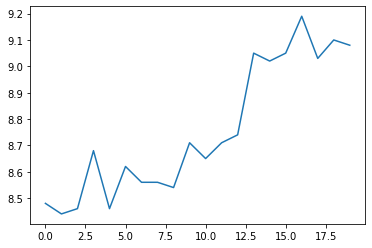

In [18]:
plt.plot(np.max(recovery_rate[:20], axis=1))

In [649]:
data['Voltage(V)'][2682946]

3.8953

In [645]:
2682946 in ref

True

In [ ]:
recovery_time[21868]

In [ ]:
recovery_volt[21867]

In [886]:
(recovery_volt[26080][0] - recovery_volt[26080][2]) * 100

0.45999999999999375

In [ ]:
np.max(recovery_rate[21865:21875], axis=1)

In [425]:
np.max(recovery_rate[:5], axis=1)

array([ 8.34,  8.39, -0.02,  8.67,  8.45])

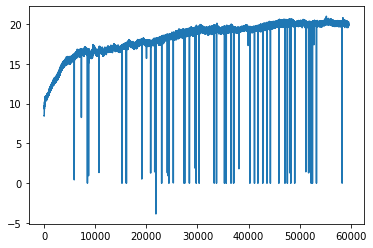

In [888]:
plt.plot(np.max(recovery_rate[:], axis=1))

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

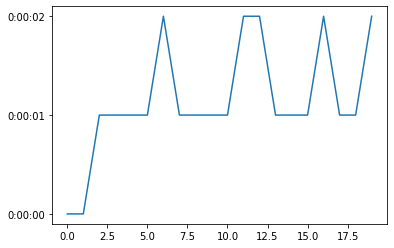

In [32]:
re_time = []

for i in recovery_time:
    re_time.append(str(i[1] - i[0]))
    
plt.plot(re_time[:20])

#### 통신 전, 통신 중, 회복 전압 그래프

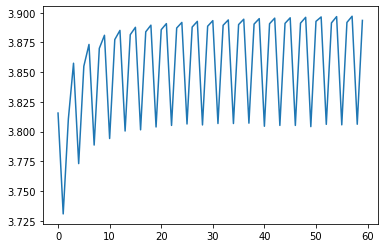

In [33]:
plt.plot(recovery_volt[:20].flatten())